# Vidsualization Loss Curve

📌 可用的 scalar tags:
['Loss/Train', 'Loss/Val']


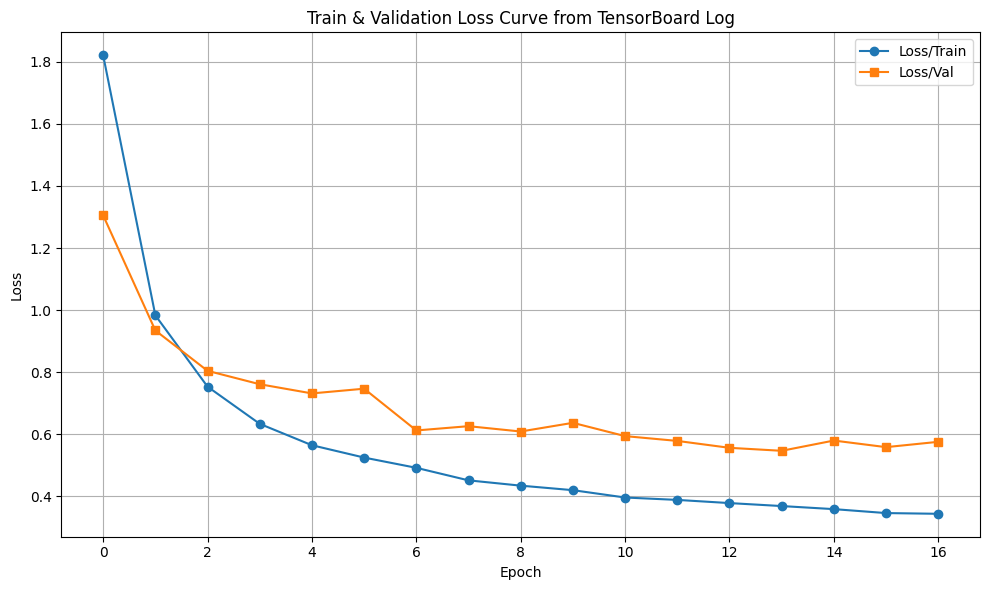

In [4]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# 配置：设置 TensorBoard 日志路径
exp_name = 'exp_cnn_gru_attn_dropout_yesAug'
exp_root = 'E:/AMR/DA/Projekt/bird_cls_cnn/projekt_LSTM/experiments'
log_dir = f"{exp_root}/{exp_name}/logs"

# 加载 TensorBoard 事件文件
event_files = [f for f in os.listdir(log_dir) if f.startswith("events.out.tfevents")]
if not event_files:
    raise FileNotFoundError("未找到 TensorBoard 日志文件，请检查路径是否正确。")

event_path = os.path.join(log_dir, event_files[0])
event_acc = EventAccumulator(event_path)
event_acc.Reload()

# 打印所有可用 scalar tags
available_tags = event_acc.Tags()["scalars"]
print("📌 可用的 scalar tags:")
print(available_tags)

# 自动选择最接近的 tag（或手动改成实际 tag）
train_tag = next((tag for tag in available_tags if "Train" in tag), None)
val_tag = next((tag for tag in available_tags if "Val" in tag or "Validation" in tag), None)

if not train_tag or not val_tag:
    raise KeyError("未找到包含 Train 或 Validation 的 scalar tag，请检查日志记录的名称。")

train_events = event_acc.Scalars(train_tag)
val_events = event_acc.Scalars(val_tag)

# 提取 step 和 value
train_steps = [e.step for e in train_events]
train_values = [e.value for e in train_events]

val_steps = [e.step for e in val_events]
val_values = [e.value for e in val_events]

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_values, label=f"{train_tag}", marker="o")
plt.plot(val_steps, val_values, label=f"{val_tag}", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Validation Loss Curve from TensorBoard Log")
plt.legend() 
plt.grid(True)
plt.tight_layout()
plt.show()


# Evaluation LSTM

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

from model.model import (
    BirdSoundGRU_Baseline,
    BirdSoundGRU_AvgPool,
    BirdSoundGRU_Attn,
    BirdSoundCNNGRU,
    BirdSoundCNNGRU_Attn,
    BirdSoundCNNGRU_MultiHeadAttn,
    BirdSoundCNNGRU_Attn_Dropout,
    build_model
)
from data.dataset import get_loader
from data.utils_bird_mapping import get_class_labels, build_index_to_label
from bird_name_mapping import bird_name_mapping  # ✅ 替换为你的实际映射

# ⚙️ 配置项
exp_name = 'exp_cnn_gru_attn_dropout_resnorm_yesAug'  # 自定义
model_name = 'best_model'
gru_type = 'cnn_gru_attn_resnorm'  # 选项: gru_base | gru_avg | gru_attn | cnn_gru

CONFIG = {
    "valid_csv": "E:/AMR/DA/Projekt/data/data_list/0408/valid_list_high_quality.csv",
    "model_path": f"E:/AMR/DA/Projekt/bird_cls_cnn/projekt_LSTM/experiments/{exp_name}/models/{model_name}.pth",
    "output_dir": f"E:/AMR/DA/Projekt/bird_cls_cnn/projekt_LSTM/experiments/{exp_name}/eval_results_{model_name}",
    "num_classes": len(set(bird_name_mapping.values())),
    "batch_size": 32,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "hidden_dim": 128,
    "num_layers": 2,
    "bidirectional": True,
    "gru_type": gru_type,
}

os.makedirs(CONFIG["output_dir"], exist_ok=True)

# 📋 标签映射
class_labels = get_class_labels(bird_name_mapping, merge_names=True)
index_to_bird = build_index_to_label(bird_name_mapping, merge_names=True)

# 📦 数据加载器
test_loader = get_loader(
    csv_path=CONFIG["valid_csv"],
    bird_name_mapping=bird_name_mapping,
    batch_size=CONFIG["batch_size"],
    num_workers=4,
    augment=False,
    use_weighted_sampler=False,
    max_samples=2000
)

# ✅ 加载模型
model = build_model(CONFIG).to(CONFIG["device"])
model.load_state_dict(torch.load(CONFIG["model_path"], map_location=CONFIG["device"]))
model.eval()

# 🔍 推理函数
def evaluate(model, loader, device):
    all_preds, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            probs = torch.softmax(logits, dim=1)
            _, preds = torch.max(probs, 1)
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

# ✅ 执行推理
true_labels, pred_labels, prob_scores = evaluate(model, test_loader, CONFIG["device"])

# 📈 准确率和报告
accuracy = accuracy_score(true_labels, pred_labels)
report = classification_report(true_labels, pred_labels, target_names=class_labels, digits=4)
report_path = os.path.join(CONFIG["output_dir"], "classification_report.txt")
with open(report_path, "w") as f:
    f.write(report)
print(f"✅ 分类报告已保存至: {report_path}")

# 🔵 混淆矩阵
conf_matrix = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(14, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig(os.path.join(CONFIG["output_dir"], "confusion_matrix.png"))
plt.show()

# 🔷 归一化混淆矩阵
conf_matrix_norm = conf_matrix.astype("float") / conf_matrix.sum(axis=1, keepdims=True)
plt.figure(figsize=(14, 10))
sns.heatmap(conf_matrix_norm, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.savefig(os.path.join(CONFIG["output_dir"], "confusion_matrix_normalized.png"))
plt.show()

# 🔺 ROC 曲线
true_bin = label_binarize(true_labels, classes=np.arange(CONFIG["num_classes"]))
colors = plt.cm.get_cmap('tab10', CONFIG["num_classes"])
plt.figure(figsize=(8, 6))
for i in range(CONFIG["num_classes"]):
    fpr, tpr, _ = roc_curve(true_bin[:, i], prob_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{class_labels[i]} (AUC={roc_auc:.2f})", color=colors(i))
plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig(os.path.join(CONFIG["output_dir"], "roc_curve.png"))
plt.show()

# 📑 结果保存
df = pd.DataFrame({
    "True Label": [class_labels[i] for i in true_labels],
    "Predicted Label": [class_labels[i] for i in pred_labels]
})
for i, name in enumerate(class_labels):
    df[f"Confidence_{name}"] = prob_scores[:, i]
df.to_csv(os.path.join(CONFIG["output_dir"], "evaluation_results.csv"), index=False, encoding="utf-8-sig")
print("📊 推理结果已保存 ✅")


📊 LSTM 数据集构建完成：共 9900 条样本，类别数：33


ValueError: ❌ 未知的 gru_type: exp_cnn_gru_attn_dropout_yesAug

# infer代码

In [4]:
from utils.infer_utils import infer_audio
from bird_name_mapping import bird_name_mapping
cfg = {
    "gru_type": "cnn_gru_attn_dropout",
    "model_path": "E:/AMR/DA/Projekt/bird_cls_cnn/projekt_LSTM/experiments/exp_cnn_gru_attn_dropout_yesAug/models/best_model.pth",
    "device": "cuda",
    "num_classes": len(bird_name_mapping),
    "dropout_rate": 0.3,
    "input_dim": 256,
    "hidden_dim": 128,
    "num_layers": 2,
    "bidirectional": True,
    "num_heads": 4,
    "fs": 48000,
    "n_fft": 512,
    "win_size": 512,
    "win_lap": 384,
    "min_freq": 150,
    "max_freq": 15000,
    "segment_duration": 3,
    "spec_size": (512, 256),
    "output_dir": "E:/AMR/DA/Projekt/bird_cls_cnn/projekt_LSTM/experiments/exp_cnn_gru_attn_dropout_yesAug/infer",
    "infer_name": "ZOOM006"
}
infer_audio("E:/AMR/DA/Projekt/data/data_from_betreuer/Elisenbrunnen/12.05.2015/ZOOM0006_Tr34_0_00000_000.wav", cfg)

c:\Users\40920\anaconda3\envs\trainenv\lib\site-packages\librosa\feature\spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


✅ 推理完成，结果已保存至 E:/AMR/DA/Projekt/bird_cls_cnn/projekt_LSTM/experiments/exp_cnn_gru_attn_dropout_yesAug/infer\ZOOM006
